# Air Quality Data Analysis Workshop
## Predicting PM2.5 Levels in African Cities

**Learning Objectives:**
By completing this workshop, you will be able to:
- Handle time-series data with geographical groupings
- Understand the challenges of missing data in time-series
- Apply appropriate cross-validation strategies for grouped data
- Perform feature engineering on temporal and geographical data
- Build and evaluate regression models for environmental data
 
**Context:**
Air quality is a critical environmental and health issue. PM2.5 (particulate matter ≤ 2.5 micrometers) is particularly dangerous as these tiny particles can penetrate deep into lungs and bloodstream.

This dataset contains air quality measurements from 4 African cities over time. Unlike typical machine learning problems, this data has **temporal dependencies** and **geographical groupings** 
that require special handling.

***
# 1. Data Loading and Initial Exploration
 
Let's start by importing the necessary libraries and loading our data.

In [368]:
import math
from datetime import datetime as dt
from operator import index

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
from babel.util import distinct
from google.protobuf.internal.testing_refleaks import TestCase
from keras.src.backend import scatter
from networkx import config
from pandas import to_datetime
from past.builtins import apply
from pdoc.docstrings import numpy
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
import warnings

from tensorboard import summary
from tensorboard.notebook import display
from tensorflow import unique

warnings.filterwarnings("ignore")

In [369]:
# Configuration class to keep our paths and column names organized
class Config:
    path = "../data/"
    id_col = "id"
    target_col = "pm2_5"

In [370]:
# TODO Load the training and test datasets
# The training set contains our target variable (pm2_5) that we want to predict
# The test set is what we'll make predictions on (without knowing the true pm2_5 values)

train_DS = pd.read_csv(Config.path + "train.csv", sep=",")
test_DS = pd.read_csv(Config.path + "test.csv", sep=",")

**Exercise:** Explore the basic structure of our data.

Use pandas methods to understand:
- What columns do we have?
- What are the data types?
- How much data is in each dataset?

In [371]:
# TODO Print the shape of these datasets

print(train_DS.shape)
print(test_DS.shape)


(8071, 80)
(2783, 79)


In [372]:
# TODO Display basic information about the training dataset

test_DS.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2783 entries, 0 to 2782
Data columns (total 79 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   id                                                        2783 non-null   object 
 1   site_id                                                   2783 non-null   object 
 2   site_latitude                                             2783 non-null   float64
 3   site_longitude                                            2783 non-null   float64
 4   city                                                      2783 non-null   object 
 5   country                                                   2783 non-null   object 
 6   date                                                      2783 non-null   object 
 7   hour                                                      2783 non-null   int64  
 8   sulphurdioxide_so2

In [373]:
# TODO Display the first few rows to understand the data structure

train_DS.head(10)


,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,...,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-10-25,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000
1,id_bkg215syli,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-02,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-03,13,NaN,NaN,...,6791.682888,51171.802486,5791.682829,11.816715,0.192757,-96.411890,61.045123,-121.307414,41.898269,39.450741
3,id_9aandqzy4n,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-08,14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.537600
4,id_ali5x2m4iw,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-09,13,0.000267,0.774656,...,1451.050659,96215.906250,451.050598,10.521009,0.153114,-97.811241,49.513439,-126.064453,40.167355,19.431731
5,id_iwv3za16vc,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-10,13,-0.000130,0.683252,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.032250
6,id_jsxdghr248,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-11,13,0.000018,1.093447,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.417667
7,id_275xmh4mpv,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-15,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,272.091429
8,id_ym8cixcegi,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-16,13,0.000163,0.334319,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.559000
9,id_02mf0t6b64,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-17,12,0.000114,0.595891,...,4058.409668,71396.875000,3058.409668,4.432884,0.214505,73.518120,38.779526,-142.403320,32.381641,154.909800


**Exercise:** Explore the geographical and temporal scope.

Find out:
- Which countries and cities are in our dataset?
- What is the time range of our data?


In [374]:
# TODO Print unique countries and cities

print(train_DS["city"].value_counts())


city
Kampala      5596
Nairobi      1500
Lagos         852
Bujumbura     123
Name: count, dtype: int64


In [375]:
# TODO Print the time range of our data

print(train_DS["date"].head(1).values)
print(train_DS["date"].tail(1).values)


['2023-10-25']
['2024-01-27']


In [376]:
# Date adaptation 

train_DS["date"] = pd.to_datetime(train_DS["date"], format="%Y-%m-%d")

reference_date = min(train_DS['date'])
train_DS['date_as_float'] = (train_DS['date'] - reference_date).dt.days


***
# 2. Data Visualization and Pattern Discovery
  
Before building models, we need to understand our data patterns. For air quality data, it's crucial to understand temporal trends and city-specific patterns. However, creating effective data visualizations requires more than just plotting data points—it demands thoughtful design choices that follow established principles for clear communication.

**Exercise:** Configure global visualization styling for professional charts

Effective data visualization requires consistent styling that eliminates visual clutter and ensures accessibility. As demonstrated in the air quality workshop, establishing global styling parameters creates a foundation for clean, professional charts throughout your analysis. This configuration applies principles of visual hierarchy and accessibility without requiring manual styling for each individual plot.

**Documentation references:**
- [Seaborn style control](https://seaborn.pydata.org/generated/seaborn.set_style.html)
- [Seaborn color palettes](https://seaborn.pydata.org/generated/seaborn.set_palette.html)
- [Colorblind-friendly design](https://seaborn.pydata.org/tutorial/color_palettes.html#qualitative-color-palettes)

Configure global styling settings by implementing a clean "white" background style that removes unnecessary visual elements while maintaining essential chart components. Remove grid lines and top/right spines to reduce clutter, but preserve left and bottom spines for data reference. Set slightly thicker axis lines for subtle emphasis. Additionally, apply a colorblind-friendly palette to ensure accessibility for users with color vision deficiency, making your visualizations inclusive for approximately 8% of the population.

In [377]:
# TODO Set global seaborn style - clean background without grid

sns.set_style("white")


In [378]:
# TODO Set inclusive and colorblind-friendly palette
# Using 'colorblind' palette which is accessible to colorblind users
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

**Exercise:** Select appropriate visualization for air quality data analysis

Air quality data contains PM2.5 measurements taken at discrete time points, requiring careful visualization choices to avoid misrepresentation. Understanding which chart type best represents your data prevents misleading interpretations about pollution patterns. Consider how air quality monitoring works: measurements are individual observations at specific moments, not continuous streams of data.

**Documentation references:**
- [Seaborn plot types overview](https://seaborn.pydata.org/tutorial/function_overview.html)
- [Matplotlib plot gallery](https://matplotlib.org/stable/gallery/index.html)
- [Choosing the right chart type](https://seaborn.pydata.org/tutorial/introduction.html#choosing-plot-types)

Examine your air quality dataset and identify the most appropriate visualization for analyzing PM2.5 levels over time for a single city. Consider these options:
- **Line plot**: Connects all measurement points with continuous lines
- **Scatter plot**: Shows individual measurements as discrete points without connection
- **Bar plot**: Shows each measurement as a separate categorical value
- **Histogram**: Shows distribution of PM2.5 values across time periods

Which visualization best represents the discrete nature of air quality measurements while still showing temporal patterns? Consider that PM2.5 readings are individual observations at specific times, not continuous processes, yet you want to identify underlying trends without implying false continuity between measurements.

**Exercise:** Implement professional air quality visualization

Implement your selected visualization technique to display PM2.5 levels over time for Lagos city, ensuring the representation accurately reflects the measurement methodology. Your visualization should clearly show individual observations while maintaining clean, accessible design principles and scientific accuracy.

**Documentation references:**
- [plt.figure()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html) - Create figure and axes for visualization
- [Matplotlib plotting functions](https://matplotlib.org/stable/api/pyplot_summary.html) - Various plotting methods available
- [Seaborn statistical plotting](https://seaborn.pydata.org/api.html) - High-level statistical visualization functions
- [Adding trend analysis](https://numpy.org/doc/stable/reference/routines.polynomials.polynomial.html) - Mathematical functions for pattern identification

In [379]:
# TODO Write a function to plot air quality data for a specific city
def plot_air_quality_subplot(train_data, city_name, ax):
    """
    Create air quality visualization for use in subplots

    Parameters:
    - train_data: DataFrame containing training data with 'date', 'pm2_5', 'city' columns
    - city_name: Name of the city to filter data for
    - ax: Matplotlib Axes object to plot on

    Returns:
    - ax: The Axes object with the plot for further customization
    
    ADAPTATIONS FOR SUBPLOT:
    - Receives ax parameter instead of creating plt.figure()
    - Uses ax.scatter() and ax.plot() instead of plt.scatter() and plt.plot()
    - Returns the ax object for further customization
    - Removes plt.show() (handled by parent function)
    """
    # Step 1: Prepare data for the specified city
    # Step 2: Create a plot for discrete measurements
    # Step 3: Add polynomial trend line to show underlying pattern
    # Step 4: Add clear, descriptive title
    # Step 5: Label axes with units
    # Step 6: Improve date readability
    # Step 7: Add legend (optional for subplots)
    
    data_city = train_data[train_data['city'] == city_name]

    sns.scatterplot(data=data_city, x="date_as_float", y='pm2_5', label=city_name, ax=ax)
    sns.regplot(data=data_city, x="date_as_float", y="pm2_5", scatter=False, color="red", order=2, label="Polynomial trend line of order 2", ax=ax)
    
    #ax.set_title(f"Air Quality in {city_name}")

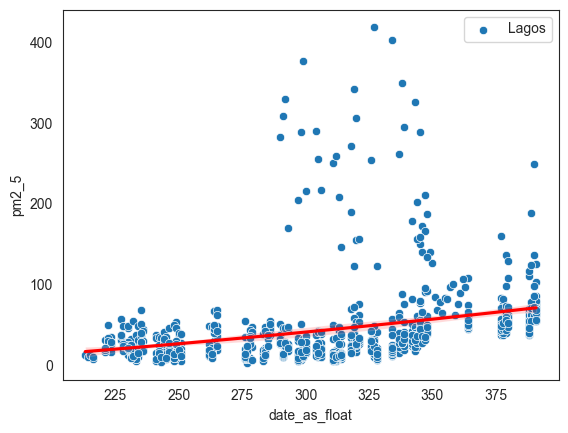

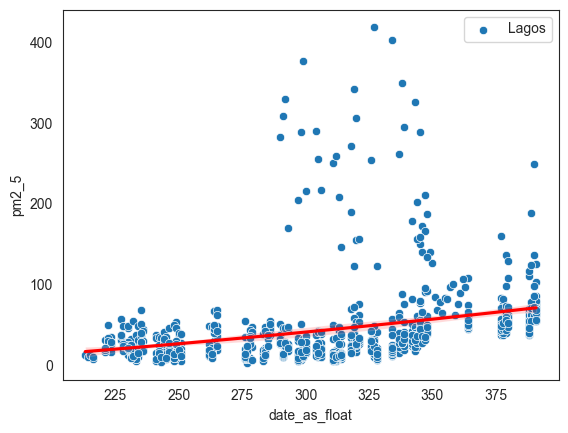

In [380]:
# TODO Create a single subplot for Lagos

fig_1, ax = plt.subplots()

plot_air_quality_subplot(train_DS, "Lagos", ax)

fig_1

**Exercise:** Create multi-city air quality comparison visualization

Comparing air quality across multiple cities requires careful visual design to avoid overwhelming the audience. Using separate subplots for each city creates visual clutter and makes direct comparison difficult.



In [381]:
# TODO Get all unique cities from the dataset
cities = np.unique(train_DS['city'])
#cities

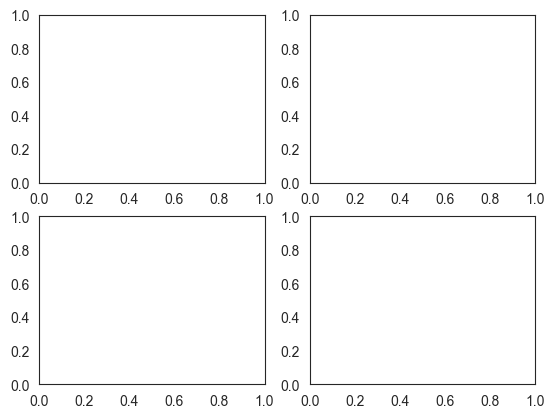

In [382]:
# TODO Create 2x2 subplot structure for all cities

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()


In [383]:
# TODO Plot each city using the subplot function

for i, city in enumerate(cities):
    plot_air_quality_subplot(train_DS, city, axes[i])
#fig

In [384]:
# TODO Add overall title for the entire figure

fig.suptitle("pm2.5 levels in different cities")

Text(0.5, 0.98, 'pm2.5 levels in different cities')

In [385]:
# TODO Optimize layout to prevent overlap and show the plot
fig.tight_layout()
#fig

**Exercise:** Improve subplot comparability

Look at the current multi-city visualization. What problem do you observe when trying to compare PM2.5 levels between different cities in the current visualization?

To make visual comparison possible, all subplots need the same y-axis limits.

Modify the code above to:
- Calculate the global minimum and maximum PM2.5 values across all cities before creating the subplots
- Apply these fixed limits with `set_ylim` to each subplot's y-axis to ensure consistent scaling

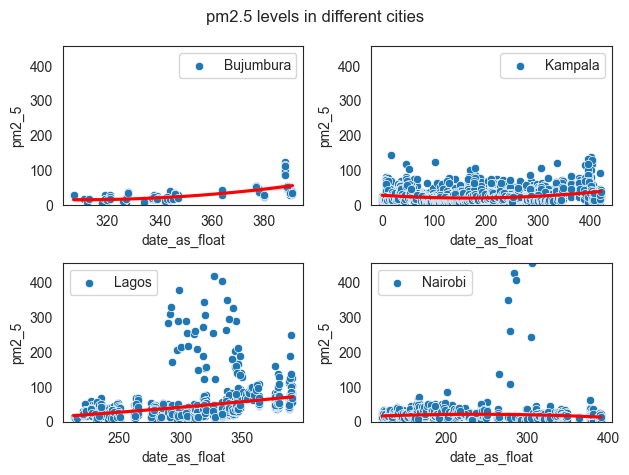

In [386]:
# TODO Create 2x2 subplot structure for all cities with the same max y value

y_max = max(train_DS["pm2_5"])

for ax in axes:
    ax.set_ylim(bottom=0, top=y_max)
    
fig

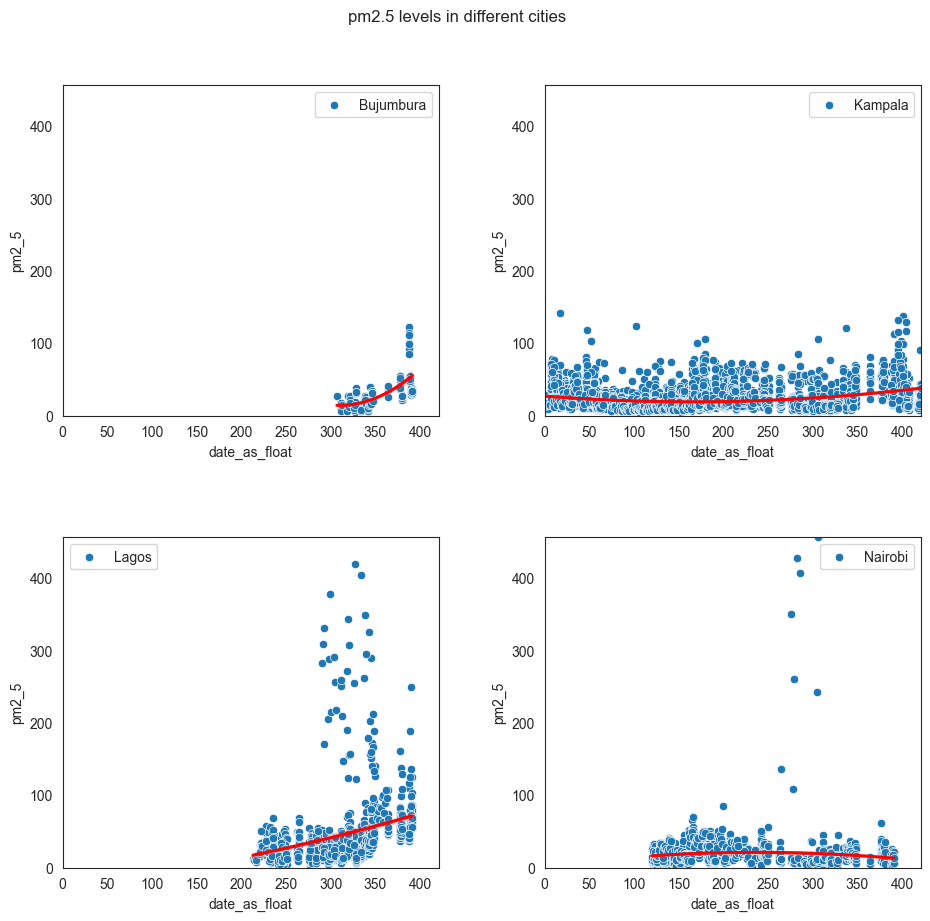

In [387]:
# and for the date also
    
date_min = min(train_DS['date_as_float'])
date_max = max(train_DS['date_as_float'])

for ax in axes:
    ax.set_xlim(left=date_min, right=date_max)

fig.set_size_inches(10, 10)

fig

***
# 3. Data Cleaning and Missing Value Handling
 
Real-world data often contains missing values that can significantly impact model performance. For time-series air quality data, missing values are particularly challenging because they can break temporal patterns and relationships. We need specialized approaches that preserve the sequential nature of our data while maintaining geographic consistency across different monitoring stations.

## 3.1 Missing Data Exploration

Understanding missing data patterns is crucial before applying any cleaning strategy. Identifying which variables have missing data and their patterns helps us choose appropriate imputation strategies.

**Documentation references:**
- [pandas.DataFrame.isnull()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html)
- [Missing data handling in pandas](https://pandas.pydata.org/docs/user_guide/missing_data.html)

**Exercise:** Identify missing data patterns across variables
- Which columns have missing values?
- What percentage of data is missing in each column?
  
Generate a two-column DataFrame summarizing missing data patterns in the training dataset  with `Missing_Count` (absolute number of missing values) and `Missing_Percentage` (percentage of missing data per column). Sort the results by missing percentage in descending order and display only columns that contain at least one missing value to identify data quality issues.


In [388]:
# TODO Generate a summary of missing data in the training set

missing_data = train_DS.isnull().apply(func=sum)

#missing_data

missing_percentage = (missing_data / train_DS.shape[0]) * 100

missing_percentage

id                            0.000000
site_id                       0.000000
site_latitude                 0.000000
site_longitude                0.000000
city                          0.000000
                               ...    
cloud_sensor_zenith_angle    38.124148
cloud_solar_azimuth_angle    38.124148
cloud_solar_zenith_angle     38.124148
pm2_5                         0.000000
date_as_float                 0.000000
Length: 81, dtype: float64

In [389]:
# Create a summary DataFrame for missing data

missing_summary = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percentage
}).sort_values('Missing_Percentage', ascending=False)

print("Missing data summary:")
print(missing_summary[missing_summary['Missing_Count'] > 0].to_string())

Missing data summary:
                                                          Missing_Count  Missing_Percentage
uvaerosollayerheight_aerosol_height                                7644           94.709454
uvaerosollayerheight_solar_zenith_angle                            7644           94.709454
uvaerosollayerheight_solar_azimuth_angle                           7644           94.709454
uvaerosollayerheight_sensor_azimuth_angle                          7644           94.709454
uvaerosollayerheight_sensor_zenith_angle                           7644           94.709454
uvaerosollayerheight_aerosol_optical_depth                         7644           94.709454
uvaerosollayerheight_aerosol_pressure                              7644           94.709454
nitrogendioxide_no2_slant_column_number_density                    4967           61.541321
nitrogendioxide_no2_column_number_density                          4967           61.541321
nitrogendioxide_tropospheric_no2_column_number_density    

**Exercise:** Remove columns with excessive missing data
 
Variables with too much missing data provide little useful information. Removing them prevents our models from learning unreliable patterns based on sparse data.
Remove columns with more than 70% missing data from both training and test datasets. Print the names of dropped columns and verify the new dataset dimensions to ensure data quality standards are maintained.

In [390]:
# TODO Remove columns with excessive missing data

columns_to_drop = missing_summary[missing_summary['Missing_Percentage'] > 70].index

if len(columns_to_drop) > 0:
    train_DS = train_DS.drop(columns_to_drop, axis=1)

train_DS


,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,...,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,date_as_float
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-10-25,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000,297
1,id_bkg215syli,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-02,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200,305
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-03,13,NaN,NaN,...,51171.802486,5791.682829,11.816715,0.192757,-96.411890,61.045123,-121.307414,41.898269,39.450741,306
3,id_9aandqzy4n,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-08,14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.537600,311
4,id_ali5x2m4iw,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-09,13,0.000267,0.774656,...,96215.906250,451.050598,10.521009,0.153114,-97.811241,49.513439,-126.064453,40.167355,19.431731,312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8066,id_ov6ddbfdf0,647f3a5d69df500029a2fc93,-1.268877,36.819139,Nairobi,Kenya,2024-01-17,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.086071,381
8067,id_3tv6i1a09t,647f3a5d69df500029a2fc93,-1.268877,36.819139,Nairobi,Kenya,2024-01-24,11,-0.000563,0.595788,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.110000,388
8068,id_csqjqt3f9i,647f3a5d69df500029a2fc93,-1.268877,36.819139,Nairobi,Kenya,2024-01-25,11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.080000,389
8069,id_tv6dzkz7ii,647f3a5d69df500029a2fc93,-1.268877,36.819139,Nairobi,Kenya,2024-01-26,10,-0.000188,0.746123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.026750,390


In [391]:
# Delete the same collumns for the test DS

if len(columns_to_drop) > 0:
    test_DS = test_DS.drop(columns_to_drop, axis=1)
    

## 3.2 Forward-backward fill for time-series missing data

Time-series data has temporal dependencies where adjacent time points are correlated. For air quality measurements, if PM2.5 is missing at 3 PM, the values at 2 PM and 4 PM are likely good estimates. Forward fill uses the last known value (2 PM → 3 PM), while backward fill uses the next known value (4 PM → 3 PM). Combining both methods ensures gaps at the beginning and end of time series are also filled, maximizing data retention while preserving temporal patterns.

- **Forward fill (ffill)**: Use the last known value
- **Backward fill (bfill)**: Use the next known value

**IMPORTANT**: We must apply this **within each city** because each city has its own air quality patterns, measurement conditions, and temporal dynamics, so imputation should respect these geographic boundaries.

**Documentation references:**
- [pandas.DataFrame.ffill()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ffill.html)
- [pandas.DataFrame.bfill()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.bfill.html)
- [pandas.DataFrame.groupby().transform()](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.transform.html)

**Exercise:** Build temporal imputation function for geographic groups
 
Each city has unique pollution patterns that shouldn't be mixed. Creating a function ensures consistent data processing across the entire pipeline.
 
Build a function that sorts data by group and date, then applies forward fill followed by backward fill within each group using pandas `.ffill()` and `.bfill()` methods. 
This ensures missing values are filled using temporally adjacent data points while respecting geographic boundaries (each city's data is processed separately).

In [392]:
# TODO Define a function to fill missing values using forward and backward fill
def forward_back_fill(df, cols, group_col, date_col):
    """
    Fill missing values using forward and backward fill within each group.

    Parameters:
    - df: DataFrame to process
    - cols: List of columns to fill
    - group_col: Column to group by (e.g., 'city')
    - date_col: Date column for sorting

    Returns:
    - DataFrame with missing values filled
    """
    # Sort by group and date to ensure proper temporal order
    # Apply forward fill then backward fill for each col within each group
    
    df_sorted = df.sort_values(by=[group_col, date_col]).copy()
    
    for col in cols:
        df_sorted[col] = df_sorted.groupby(group_col)[col].ffill()
        df_sorted[col] = df_sorted.groupby(group_col)[col].bfill()
        
    return df_sorted

**Exercise:** Process missing data within each city independently for both training and test datasets.

Loop through each city and for each dataset extract that city's data, identify columns with missing values, apply the forward-backward fill function, then update the original dataset. This ensures that each city's missing values are filled using only that city's own temporal patterns, maintaining geographic consistency across the entire pipeline.

In [393]:
# TODO Process both datasets city by city
    # Process training data for this city   
    
missing_counts = train_DS.isna().sum()
cols_to_fill = missing_counts[missing_counts > 0].index.tolist()

train_DS_filled = forward_back_fill(train_DS, cols_to_fill, "city", "date")

    # Process test data for this city
    
missing_counts = test_DS.isna().sum()
cols_to_fill = missing_counts[missing_counts > 0].index.tolist()

test_DS_filled = forward_back_fill(test_DS, cols_to_fill, "city", "date")



In [394]:
# Verify that missing values have been handled

print("Missing values after cleaning:")
print(f"Train: {train_DS_filled.isnull().sum().sum()}")
print(f"Test: {test_DS_filled.isnull().sum().sum()}")

Missing values after cleaning:
Train: 0
Test: 0


In [395]:
# Replace train_DS by train_DS_filled & same for test_DS

train_DS = train_DS_filled
test_DS = test_DS_filled


***
# 4. Understanding Cross-Validation Strategy for Grouped Data
 
Our data has an important characteristic: observations are grouped by city. Cities might have different climate patterns, pollution sources, or measurement conditions. Using random train/test splits could put data from the same city in both training and validation sets, leading to data leakage and overly optimistic performance estimates. We need a specialized cross-validation approach that respects these geographical groupings.

## 4.1 The Problem with Standard Cross-Validation

Standard k-fold cross-validation randomly splits data into folds, which can create data leakage when observations are naturally grouped. For geographical data like ours, this means a model could see data from Lagos in training and then be tested on different Lagos data points, artificially inflating performance metrics because cities have consistent internal patterns.

**Documentation references:**
- [Cross-validation overview](https://scikit-learn.org/stable/modules/cross_validation.html)
- [Data leakage in machine learning](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-for-grouped-data)

**Exercise:** Understand why city grouping matters for validation

Each city has unique pollution characteristics that create internal consistency. Random splitting would allow models to exploit these city-specific patterns rather than learning generalizable relationships.

Examine the unique cities in your training data and consider how many data points each city contributes. Think about what would happen if training data included some Lagos measurements and validation data included other Lagos measurements - would this give us realistic performance estimates for predicting air quality in completely new cities?

In [396]:
# TODO Print the number of measurements by city in our dataset

print(train_DS["city"].value_counts())

city
Kampala      5596
Nairobi      1500
Lagos         852
Bujumbura     123
Name: count, dtype: int64


## 4.2 GroupKFold Solution

GroupKFold ensures that entire cities are either in training OR validation, never both. This provides more realistic performance estimates by testing the model's ability to generalize to completely unseen locations, which better reflects real-world deployment scenarios.

**Documentation references:**
- [GroupKFold documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html)
- [Grouped data cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#group-k-fold)

**Exercise:** Create city-based cross-validation folds

GroupKFold prevents data leakage by keeping all data from each city together. This tests our model's ability to generalize to new cities rather than memorizing city-specific patterns.
Use GroupKFold with 4 splits to create folds where each fold contains complete cities. Set the groups parameter to the city column so that all measurements from the same city stay together. Store the fold assignments in a new 'folds' column for later use.

In [397]:
# TODO Create city-based folds using GroupKFold
# Each fold will contain complete cities, not random samples
# The 'groups' parameter tells GroupKFold which samples belong to the same group (city)
# Convert to integer type for easier handling

train_DS = train_DS.reset_index(drop=True)

gkf = GroupKFold(n_splits=4)

X = train_DS.drop(columns="pm2_5")
y = train_DS["pm2_5"]
groups = train_DS["city"]

for fold, (train_index, test_index) in enumerate(gkf.split(X, y, groups=groups)):
    train_DS.loc[test_index, "fold"] = fold
    

In [398]:
print(f"Distribution des tailles de ville :\n{train_DS['fold'].value_counts()}")

Distribution des tailles de ville :
fold
0.0    5596
1.0    1500
2.0     852
3.0     123
Name: count, dtype: int64


**Exercise:** Verify fold distribution and balance

Understanding how cities are distributed across folds helps ensure our validation strategy is sound. Ideally, each fold should have reasonable representation and similar target distributions.
Examine which cities are assigned to each fold and calculate basic statistics for the target variable (PM2.5) across folds. Check that folds are reasonably balanced in terms of sample size and target variable distribution to ensure robust cross-validation.

In [399]:
# TODO Check which cities are in each fold and how many samples per fold
grouped = train_DS.groupby("fold")

for fold_name, df in grouped:
    print(f"In group {int(fold_name)} : {pd.unique(df["city"])}, for {df.shape[0]} samples")


In group 0 : ['Kampala'], for 5596 samples
In group 1 : ['Nairobi'], for 1500 samples
In group 2 : ['Lagos'], for 852 samples
In group 3 : ['Bujumbura'], for 123 samples


In [400]:
# Let's also check the target distribution across folds
# We want to ensure folds are reasonably balanced

fold_stats = train_DS.groupby('fold')[Config.target_col].agg(['count', 'mean', 'std']).round(2)

print(Config.target_col + " statistics by fold:")
print(fold_stats)


pm2_5 statistics by fold:
      count   mean    std
fold                     
0.0    5596  22.77  14.35
1.0    1500  18.88  24.98
2.0     852  46.21  52.84
3.0     123  30.70  22.35


***
# 5. Feature Engineering for Time-Series and Geographic Data
 
Feature engineering is crucial for time-series data. We need to extract meaningful patterns from dates and create geographic features.

## 5.1 Temporal Feature Engineering
 
Air quality data exhibits strong temporal patterns: pollution levels vary by season (winter heating, summer ozone), day of week (weekday traffic vs weekend), and time of day (rush hours). Extracting these cyclical patterns as features helps machine learning models capture these relationships explicitly rather than trying to infer them from raw timestamps.

**Documentation references:**
- [Time series / date functionality](https://pandas.pydata.org/docs/user_guide/timeseries.html)

**Exercise:** Understanding temporal patterns in air quality
 
Before extracting features, we need to understand why temporal patterns matter for air quality prediction. 
Different times of year, days of week, and hours show different pollution patterns due to:
- Seasonal effects: winter heating, summer photochemical reactions
- Weekly cycles: higher traffic on weekdays vs weekends  
- Daily patterns: rush hour peaks, industrial activity schedules
 
Create the `extract_temporal_features` function that extracts these meaningful time components from datetime data to help our model understand when pollution is typically higher or lower.

In [401]:
# TODO Define a function to extract temporal features from a datetime column
def extract_temporal_features(df, date_col='date'):
    """
    Extract temporal features from a datetime column to capture cyclical patterns.
    
    Air quality varies with seasonal changes, weekly patterns (weekdays vs weekends),
    and daily cycles. These temporal features help models understand when pollution
    levels are typically higher or lower.

    Parameters:
    - df: DataFrame containing the date column
    - date_col: Name of the datetime column to extract features from

    Returns:
    - DataFrame with additional temporal features (year, month, day, quarter, week and dayofweek)
    """
    # Ensure the date column is datetime type for proper extraction
    # Extract basic temporal components that affect air quality
    
    df[date_col] = pd.to_datetime(df[date_col], format="%Y-%m-%d")
    
    df["year"] = df[date_col].dt.year
    df["month"] = df[date_col].dt.month
    df["day"] = df[date_col].dt.day
    df["quarter"] = df[date_col].dt.quarter
    df["week"] = df[date_col].dt.isocalendar().week
    df["dayofweek"] = df[date_col].dt.dayofweek
    
    return df
    

**Exercise:** Apply temporal feature engineering to both datasets

Use your function to extract temporal features from both training and test datasets. This ensures both datasets have the same feature structure for consistent model training and prediction.

In [402]:
# TODO Apply temporal feature to train & test sets

train_DS = extract_temporal_features(train_DS)
test_DS = extract_temporal_features(test_DS)


In [403]:
# Display the new temporal features

print("New temporal features created:")
temporal_cols = ['year', 'month', 'day', 'quarter', 'week', 'dayofweek']
print(train_DS[['date'] + temporal_cols].head())

New temporal features created:
        date  year  month  day  quarter  week  dayofweek
0 2023-11-04  2023     11    4        4    44          5
1 2023-11-08  2023     11    8        4    45          2
2 2023-11-09  2023     11    9        4    45          3
3 2023-11-10  2023     11   10        4    45          4
4 2023-11-15  2023     11   15        4    46          2


## 5.2 Geographic Feature Engineering
 
Air quality monitoring stations at different geographic locations can have distinct pollution profiles due to local factors like traffic density, industrial proximity, topography, and meteorological conditions. Creating location-specific identifiers helps models learn these location-based patterns.

**Documentation references:**
- [pandas.DataFrame.astype()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html)
- [String concatenation in pandas](https://pandas.pydata.org/docs/user_guide/text.html#concatenation)

**Exercise 1:** Understanding the importance of geographic features
 
Different monitoring stations can have vastly different pollution levels even within the same city due to local factors like proximity to highways, industrial zones, or natural barriers.
By creating unique location identifiers, we help the model distinguish between these micro-environments and learn location-specific pollution patterns.

Implement the `extract_geographic_features` function that combines latitude and longitude coordinates to create unique `location` identifier (`latitude_longitude` format) for each monitoring station.

In [404]:
# TODO Define a function to extract geographic features from latitude and longitude coordinates
def extract_geographic_features(df):
    """
    Create geographic features from latitude and longitude coordinates.
    
    Different monitoring locations have unique pollution characteristics based on
    their surroundings (urban vs rural, near highways, industrial areas, etc.).
    Combining coordinates creates unique location identifiers that help models
    learn location-specific pollution patterns.

    Parameters:
    - df: DataFrame with site_latitude and site_latitude columns

    Returns:
    - DataFrame with additional geographic feature (location identifier)
    """
    # Create a unique location identifier by combining coordinates
    # This allows the model to learn location-specific patterns
    
    coords = []
    
    location_id = []
    
    for _, line in df.iterrows():
        try:
            loc_id = coords.index((line["site_latitude"], line["site_longitude"]))
            location_id.append(loc_id)
        except ValueError:
            coords.append((line["site_latitude"], line["site_longitude"]))
            location_id.append(len(coords) - 1)

    df["location"] = location_id


**Exercise 2:** Apply geographic feature engineering
 
Use your function to create location identifiers for both training and test datasets.
This will help the model understand that different coordinate pairs represent different pollution environments with potentially different baseline levels and patterns.

In [405]:
# TODO Apply geographic feature to train & test sets

extract_geographic_features(train_DS)
extract_geographic_features(test_DS)


In [406]:
print(f"Created {train_DS['location'].nunique()} unique locations")

Created 69 unique locations


## 5.3 Categorical Feature Encoding
 
Machine learning algorithms require numerical inputs, but our dataset contains categorical variables like location identifiers and dates. We need to convert these text-based categories into numerical representations while ensuring consistency between training and test datasets. **Label Encoding** assigns a unique integer to each category. 

**Documentation references:**
- [Label Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

**Exercise 1:** Understanding the need for categorical encoding
 
Machine learning models like Linear Regression work with numbers, not text. When we have categorical variables like location names or dates, we need to convert them to numerical format. However, we must ensure that the same category gets the same number in both training and test datasets to maintain consistency.

Implement the `encode_categorical_features` function that uses Label Encoding to convert categorical variables to integers while maintaining consistency between datasets.

In [407]:
# TODO Write a function to encode categorical features
def encode_categorical_features(train_df, test_df):
    """
    Encode categorical features for machine learning models.
    
    Most ML algorithms require numerical inputs, but our data contains categorical
    variables (location names, dates) that need conversion to numbers. We use 
    Label Encoding to assign unique integers to each category while ensuring
    consistent encoding between training and test sets.

    Parameters:
    - train_df, test_df: Training and test DataFrames with categorical features

    Returns:
    - train_encoded: Encoded training DataFrame
    - test_encoded: Encoded test DataFrame  
    - feature_cols: List of column names to use as model features
    """
    # Combine datasets to ensure consistent encoding across train/test
    # This prevents issues where test set has categories not seen in training
    # Initialize label encoder for consistent categorical-to-numerical conversion
    # Identify categorical columns that need encoding
    # These are high-cardinality categories (many unique values)
    # Apply label encoding: convert each unique category to a unique integer
    # Split back into separate train and test datasets
    # Define feature columns (exclude target variable and metadata)
    
    combined_df = pd.concat([train_df, test_df])
    
    le = LabelEncoder()
    
    cols_to_encode = ["city", "country"]
    
    for col in cols_to_encode:
        le.fit(combined_df[col])
        combined_df[col + "_encoded"] = le.transform(combined_df[col])

    not_features = cols_to_encode + ["pm2_5", "id", "site_id", "site_latitude", "site_longitude", "date", "fold"]

    feature_columns = [col for col in combined_df.columns if col not in not_features]
    
    return combined_df[combined_df["pm2_5"].notna()], combined_df[combined_df["pm2_5"].isna()], feature_columns


In [408]:
train_DS["fold"]

0       3.0
1       3.0
2       3.0
3       3.0
4       3.0
       ... 
8066    1.0
8067    1.0
8068    1.0
8069    1.0
8070    1.0
Name: fold, Length: 8071, dtype: float64

**Exercise 2:** Apply categorical encoding to prepare data for modeling

Use your function to encode categorical features in both datasets and identify which columns should be used as features for model training (excluding target variables and metadata that shouldn't influence predictions).

In [409]:
# TODO Apply the function to encode categorical features train and test sets

train_DS_encoded, test_DS_encoded, feature_cols = encode_categorical_features(train_DS, test_DS)


In [410]:
print(f"Total feature columns for modeling: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}...")

# Verify encoding worked correctly
print(f"\nData shapes after encoding:")
print(f"Training data: {train_DS_encoded.shape}")
print(f"Test data: {test_DS_encoded.shape}")

Total feature columns for modeling: 74
Feature columns: ['hour', 'sulphurdioxide_so2_column_number_density', 'sulphurdioxide_so2_column_number_density_amf', 'sulphurdioxide_so2_slant_column_number_density', 'sulphurdioxide_cloud_fraction', 'sulphurdioxide_sensor_azimuth_angle', 'sulphurdioxide_sensor_zenith_angle', 'sulphurdioxide_solar_azimuth_angle', 'sulphurdioxide_solar_zenith_angle', 'sulphurdioxide_so2_column_number_density_15km', 'month', 'carbonmonoxide_co_column_number_density', 'carbonmonoxide_h2o_column_number_density', 'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude', 'carbonmonoxide_sensor_azimuth_angle', 'carbonmonoxide_sensor_zenith_angle', 'carbonmonoxide_solar_azimuth_angle', 'carbonmonoxide_solar_zenith_angle', 'nitrogendioxide_no2_column_number_density', 'nitrogendioxide_tropospheric_no2_column_number_density', 'nitrogendioxide_stratospheric_no2_column_number_density', 'nitrogendioxide_no2_slant_column_number_density', 'nitrogendioxide_tropopause_press

In [411]:
train_DS

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,...,cloud_solar_zenith_angle,pm2_5,date_as_float,fold,year,day,quarter,week,dayofweek,location
0,id_kckponblua,64ef31227771f10013f8b066,-3.380650,29.383830,Bujumbura,Burundi,2023-11-04,11,0.000053,0.834035,...,33.186287,27.504000,307,3.0,2023,4,4,44,5,0
1,id_gshykfsukc,64ef31227771f10013f8b066,-3.380650,29.383830,Bujumbura,Burundi,2023-11-08,12,0.000053,0.834035,...,33.186287,17.272750,311,3.0,2023,8,4,45,2,0
2,id_aqxf9kcpqu,64ef31227771f10013f8b066,-3.380650,29.383830,Bujumbura,Burundi,2023-11-09,11,0.000053,0.834035,...,35.046368,6.688182,312,3.0,2023,9,4,45,3,0
3,id_wpfc6p151m,64ef31227771f10013f8b066,-3.380650,29.383830,Bujumbura,Burundi,2023-11-10,11,0.000053,0.834035,...,35.046368,15.051000,313,3.0,2023,10,4,45,4,0
4,id_8z4vuea2wl,64ef31227771f10013f8b066,-3.380650,29.383830,Bujumbura,Burundi,2023-11-15,11,0.000053,0.834035,...,32.664028,5.863500,318,3.0,2023,15,4,46,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8066,id_tn51gcoz4a,644841fe1319140029aced6e,-1.283724,36.810364,Nairobi,Kenya,2024-01-27,10,0.000199,0.764215,...,21.264854,13.334286,391,1.0,2024,27,1,4,5,62
8067,id_msdjbr87s4,644fa58ae5001000290df1e2,-1.286301,36.830761,Nairobi,Kenya,2024-01-27,10,-0.000128,0.729167,...,21.321957,21.272407,391,1.0,2024,27,1,4,5,63
8068,id_d66ohje4sb,6246f308db9c64001e483ffe,-1.235120,36.812150,Nairobi,Kenya,2024-01-27,10,0.000299,0.767461,...,21.329876,9.172387,391,1.0,2024,27,1,4,5,65
8069,id_eonffvuke4,62fe1f3d365de1001e86eb55,-1.224292,36.805005,Nairobi,Kenya,2024-01-27,10,0.000184,0.769604,...,21.329876,5.685071,391,1.0,2024,27,1,4,5,66


***
# 6. Baseline Model Development
 
Building a baseline model is essential before exploring complex algorithms. A simple Linear Regression model provides a reference point for measuring improvement and helps validate that our data preprocessing and cross-validation strategy work correctly. Starting with interpretable models also helps us understand which features are most important for air quality prediction.

## 6.1 Train-Validation Split Using Fold Strategy

We'll use our city-based folds to create a proper train-validation split that respects geographical boundaries. This ensures our baseline performance estimates are realistic and comparable to our final cross-validation results.

**Exercise:** Create geographically-separated train and validation sets

Using fold-based splitting ensures our model evaluation reflects real-world deployment conditions. We need distinct city groups for training and validation to avoid data leakage.


```
📊 FOLD-BASED DATA SPLITTING STRATEGY

Original Dataset (train_processed)
┌─────────────────────────────────────────────────────────────┐
│  FOLD 1    │  FOLD 2    │  FOLD 3    │  FOLD 4    │
│  City A    │  City B    │  City C    │  City D    │
│  [data]    │  [data]    │  [data]    │  [data]    │
└─────────────────────────────────────────────────────────────┘

                    ↓ SPLIT ↓

TRAINING DATA (Folds 1, 3, 4)          VALIDATION DATA (Fold 2)
┌─────────────────────────────────┐    ┌─────────────────────┐
│  City A + City C + City D       │    │      City B         │
│                                 │    │                     │
│  ↓ SEPARATE FEATURES & TARGET   │    │  ↓ SEPARATE FEATURES│
│                                 │    │    & TARGET         │
│  X_train: [features matrix]     │    │  X_val: [features]  │
│  y_train: [PM2.5 values]        │    │  y_val: [PM2.5]     │
└─────────────────────────────────┘    └─────────────────────┘

🎯 RESULT: Complete geographical separation
   → No city appears in both training and validation
   → Prevents data leakage and ensures realistic evaluation
```


Use folds 1, 3, 4 for training and fold 2 for validation to create train_data and val_data subsets. Then prepare feature matrices `(X_train, X_val)` and target vectors `(y_train, y_val)` using the feature_columns list from our preprocessing pipeline.

In [412]:
# TODO Select the relevant folds for train and val data

train_data = train_DS_encoded[train_DS_encoded["fold"] != 2]
val_data = train_DS_encoded[train_DS_encoded["fold"] == 2]


In [413]:
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")

Training data shape: (7219, 83)
Validation data shape: (852, 83)


In [414]:
# TODO Prepare feature matrices X_train, y_train and target vectors X_val, y_val

X_train = train_data[feature_cols]
y_train = train_data["pm2_5"]

X_val = val_data[feature_cols]
y_val = val_data["pm2_5"]

In [415]:
print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")

Training features shape: (7219, 74)
Training target shape: (7219,)


## 6.2 Linear Regression Model Training and Evaluation

Linear Regression assumes linear relationships between features and target variables. While this assumption may not hold perfectly for air quality data, it provides an interpretable baseline and helps identify the most predictive features through coefficient analysis.

Documentation references:
- [Linear Regression in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
- [Mean Squared Error](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error)
- [R² score](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination)

**Exercise:** Train baseline Linear Regression model

Establishing baseline performance helps gauge whether more complex models provide meaningful improvements. Simple models also help identify obvious data quality issues early in the pipeline.

Train a LinearRegression model on the training data, make predictions on the validation set, and calculate three key performance metrics: Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R² score to establish our baseline performance benchmark.


In [416]:
# TODO Train the model

reg = LinearRegression().fit(X_train, y_train)


In [417]:
# TODO Make predictions

prediction = reg.predict(X_val)
prediction


array([26.31926785, 28.13213179, 32.26783036, 42.08516335, 41.98306735,
       43.36482984, 43.35369758, 44.37348492, 44.28172492, 44.27059265,
       45.6909809 , 45.67984864, 45.83175593, 46.31462645, 42.90600158,
       46.21490779, 47.2002037 , 46.24577183, 45.70392004, 45.97355842,
       40.48619685, 37.18945826, 38.88615969, 38.8875952 , 41.14572952,
       39.88485552, 39.48379291, 37.88294829, 36.07433109, 32.21422141,
       36.06672421, 32.23691422, 34.69658939, 34.68547632, 40.61739932,
       40.39425282, 42.96274156, 41.69451255, 41.53750984, 41.39910251,
       41.35457346, 41.3434412 , 31.59967056, 32.23628986, 34.00532416,
       33.68863727, 34.28272184, 34.23819279, 34.22706053, 15.29504295,
       25.28292364, 21.76563094, 23.25769284, 24.87685792, 24.83232888,
       24.82119661, 13.01707743, 14.06526511, 12.74510945, 12.73397718,
       14.64242617, 14.86062144, 17.17336777, 18.53329664, 21.72562849,
       19.62608302, 18.12081682, 19.66251596, 19.88033409, 19.57

**Exercise:** Analyze baseline model performance metrics

Understanding baseline performance provides context for evaluating more sophisticated approaches. These metrics help determine if our preprocessing pipeline is working correctly and set expectations for model improvement.

Display the calculated performance metrics (MSE, RMSE, R²) with clear labels and appropriate decimal precision. Interpret what these numbers mean in the context of air quality prediction - RMSE shows average prediction error in µg/m³, while R² indicates the proportion of variance explained by the model.

In [418]:
# TODO Calculate performance metrics

mse = mean_squared_error(y_val, prediction)

r2 = r2_score(y_val, prediction)

print(f"Min gap : {min(prediction - y_val)}")
print(f"Max gap : {max(prediction - y_val)}")


Min gap : -376.00613414970803
Max gap : 38.92596138125866


In [419]:
print("Baseline Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {math.sqrt(mse):.2f}")
print(f"R² Score: {r2:4f}")

Baseline Model Performance:
Mean Squared Error (MSE): 2653.7102
Root Mean Squared Error (RMSE): 51.51
R² Score: 0.048576


---

# 7. Feature Selection for Model Improvement
 
Not all features are equally important for predicting air quality. Feature selection can improve model performance by focusing on the most relevant variables, reduce overfitting by eliminating noise, and enhance interpretability by identifying the key factors that drive PM2.5 levels. We'll explore two complementary approaches: statistical selection and recursive elimination.


## 7.1 SelectKBest Feature Selection

SelectKBest uses statistical tests to identify features with the strongest linear relationships to the target variable. For regression problems, it employs F-statistics to measure how much each feature explains the variance in PM2.5 levels. This method is fast and effective for identifying obviously important features, making it ideal for initial feature screening.

**Documentation references:**
- [SelectKBest documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)
- [f_regression scoring function](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html)
- [Feature selection guide](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)

**Exercise:** Apply statistical feature selection with `SelectKBest`

Statistical tests quickly identify features with strong predictive power. This approach helps eliminate obviously irrelevant variables before applying more sophisticated selection methods.

Initialize `SelectKBest` with `f_regression` scoring and `k=15` features. Fit the selector on training data, transform both training and validation sets, then create a summary DataFrame showing feature names, their F-scores, and selection status to understand which variables are most predictive.

In [420]:
# Select top 15 features

k_best_features = 15  

In [421]:
# TODO Initialize and fit the selector

skb = SelectKBest(f_regression, k=k_best_features)
X_train_skb = skb.fit_transform(X_train, y_train)

X_train_skb.shape


(7219, 15)

In [422]:
# TODO Get selected feature names and their scores

selected_features = skb.get_feature_names_out()
scores = skb.scores_[skb.get_support(indices=True)]


In [423]:
# TODO Create a summary DataFrame

feature_importance_df = pd.DataFrame({
    'Features' : selected_features,
    'Score' : scores
}).sort_values(by='Score', ascending=False)


In [424]:
print("Top 10 features by SelectKBest score:")
print(feature_importance_df.head(10))

Top 10 features by SelectKBest score:
                                             Features       Score
2             carbonmonoxide_co_column_number_density  892.247689
12                                               year  411.558708
9                      ozone_o3_column_number_density  286.820435
5   nitrogendioxide_tropospheric_no2_column_number...  200.714999
4           nitrogendioxide_no2_column_number_density  199.385209
10                          ozone_solar_azimuth_angle  190.274995
8                  uvaerosolindex_solar_azimuth_angle  189.874211
11                          cloud_solar_azimuth_angle  186.852643
0                  sulphurdioxide_solar_azimuth_angle  180.848077
3                  carbonmonoxide_solar_azimuth_angle  178.836712


**Exercise:** Evaluate `SelectKBest` model performance against baseline

Comparing feature selection results to the baseline helps determine if reducing dimensionality improves generalization. Sometimes fewer, more relevant features outperform using all available variables.

Train a new LinearRegression model using only the `SelectKBest` features, make predictions on the validation set, and calculate `MSE`, `RMSE` and `R²` metrics. Compare these results to the baseline performance to assess whether feature selection improved model quality.

In [425]:
X_val_skb = X_val[selected_features]

In [426]:
# TODO Train a new model using only the selected features

reg = LinearRegression().fit(X_train_skb, y_train)
prediction_skb = reg.predict(X_val_skb)
prediction_skb

array([25.59103688, 25.76344218, 26.35701369, 40.92745138, 40.32001322,
       42.89810494, 42.89810494, 42.89519217, 42.08160532, 42.08160532,
       42.28387017, 42.28387017, 42.28380603, 42.36077845, 41.62886102,
       41.56930418, 41.38980575, 41.57858437, 41.87747387, 41.70873154,
       39.22988249, 37.24053727, 36.94146095, 37.14534453, 36.97027896,
       36.46984927, 36.6059068 , 37.06312654, 36.43678411, 43.02691097,
       43.31032068, 43.0269104 , 45.37891263, 45.37891261, 46.84341088,
       46.86333604, 47.2211001 , 47.22159768, 47.44748474, 47.03914147,
       47.03914147, 47.03914147, 33.25257965, 33.74182273, 33.715039  ,
       33.95801428, 33.42483987, 33.42483987, 33.42483987, 25.31121687,
       29.60957645, 30.75750534, 31.96370842, 30.83178939, 30.83178939,
       30.83178939, 23.68978468, 18.17116787, 20.19592682, 20.19592682,
       24.62491846, 26.55006595, 25.63087853, 25.26721767, 25.71426977,
       25.67273335, 25.27927797, 25.67108863, 25.22148867, 25.53

In [436]:
# TODO Compute performance metrics for the SelectKBest model
mse_kbest = mean_squared_error(y_val, prediction_skb)

r2_kbest = r2_score(y_val, prediction_skb)

print(f"Min gap : {min(prediction - y_val)}")
print(f"Max gap : {max(prediction - y_val)}")



Min gap : -376.00613414970803
Max gap : 38.92596138125866


In [437]:
print("SelectKBest Model Performance:")
print(f"MSE: {mse_kbest:.2f} (baseline: {mse:.2f})")
print(f"RMSE: {math.sqrt(mse_kbest):.2f} (baseline: {math.sqrt(mse):.2f})")
print(f"R² Score: {r2_kbest:.4f} (baseline: {r2:.4f})")

SelectKBest Model Performance:
MSE: 2630.41 (baseline: 2653.71)
RMSE: 51.29 (baseline: 51.51)
R² Score: 0.0569 (baseline: 0.0486)


## 7.2 Recursive Feature Elimination (RFE)

RFE takes a different approach by iteratively training models and eliminating the least important features based on model coefficients. This method considers feature interactions and dependencies that univariate tests might miss, potentially finding more nuanced feature combinations that work well together for air quality prediction.

**Documentation references:**
- [Recursive feature elimination guide](https://scikit-learn.org/stable/modules/feature_selection.html#recursive-feature-elimination)
- [RFE documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

**Exercise:** Apply model-based feature selection with RFE

`RFE` considers how features work together within the model context. Unlike statistical tests, it accounts for feature interactions and multicollinearity when making selection decisions.

Initialize `RFE` with `LinearRegression` as the estimator and select `15` features. Fit `RFE` on training data, transform both datasets, then examine the selected features and their model coefficients to understand which variables the model considers most important in combination.

In [429]:
# Select top 15 features
rfe_features = 15  

In [445]:
# TODO Initialize RFE with LinearRegression as the estimator

rfe = RFE(LinearRegression(), n_features_to_select = rfe_features)


In [449]:
# TODO Fit RFE and transform features

X_train_rfe = rfe.fit_transform(X_train, y_train)


In [450]:
# TODO Get selected features and their rankings

selected_features_rfe = rfe.get_feature_names_out()


In [451]:
print("Features selected by RFE:")
rfe_df = pd.DataFrame({
    'Feature': selected_features_rfe,
    'Coefficient': rfe.estimator_.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(rfe_df)

Features selected by RFE:
                                              Feature   Coefficient
5   nitrogendioxide_tropospheric_no2_column_number...  76044.966783
7     nitrogendioxide_no2_slant_column_number_density  40033.769976
6   nitrogendioxide_stratospheric_no2_column_numbe...  36779.541490
4           nitrogendioxide_no2_column_number_density  20133.492651
1      sulphurdioxide_so2_slant_column_number_density  10795.048759
0            sulphurdioxide_so2_column_number_density  -3720.352893
9       formaldehyde_hcho_slant_column_number_density   2858.586870
11                     ozone_o3_column_number_density  -1955.870178
8   formaldehyde_tropospheric_hcho_column_number_d...  -1428.221023
3             carbonmonoxide_co_column_number_density    750.346151
2       sulphurdioxide_so2_column_number_density_15km   -666.752286
13               ozone_o3_slant_column_number_density    601.490435
12                 ozone_o3_column_number_density_amf    -70.729086
14                    

**Exercise:** Compare RFE performance with previous approaches

Model-based selection might identify different feature combinations than statistical tests. Comparing both approaches helps determine which selection strategy works better for our specific air quality prediction task.

Train a `LinearRegression` model using RFE-selected features, calculate performance metrics (`MSE`, `RMSE`, `R²`), and compare results with both baseline and SelectKBest approaches to identify the most effective feature selection method for this dataset.

In [452]:
X_val_rfe = X_val[selected_features_rfe]

In [454]:
# TODO Train a new model using only the selected features

reg = LinearRegression().fit(X_train_rfe, y_train)
prediction_rfe = reg.predict(X_val_rfe)
prediction_rfe


array([32.25000296, 36.19286787, 34.58436394, 46.92498856, 45.8405128 ,
       48.19621165, 48.19621165, 48.52646584, 48.1380602 , 48.1380602 ,
       44.59297386, 44.59297386, 44.74435679, 45.34744744, 44.01764239,
       44.09806891, 43.95631743, 44.10794679, 44.35192038, 44.21418161,
       41.67296744, 38.74819746, 39.87336149, 39.89981793, 40.65090075,
       40.93128648, 40.36194178, 38.63176998, 40.92529578, 42.58222008,
       43.16895732, 42.58221951, 45.80017021, 45.80017019, 49.9031405 ,
       49.01231615, 51.60829245, 50.71525924, 50.72742644, 50.36660692,
       50.36660692, 50.36660692, 36.0829161 , 36.25716003, 37.08672134,
       36.54625768, 37.40285762, 37.40285762, 37.40285762, 26.5169332 ,
       34.09867128, 34.49987516, 35.71479633, 35.69117189, 35.69117189,
       35.69117189, 23.54825644, 18.26949922, 20.08690231, 20.08690231,
       24.79156734, 27.0936369 , 22.9352979 , 23.22684216, 26.8604261 ,
       24.7397724 , 23.51093109, 24.75001136, 24.62356026, 24.71

In [455]:
# TODO Compute performance metrics for the RFE model
# Display RFE model performance

mse_rfe = mean_squared_error(y_val, prediction_rfe)

r2_rfe = r2_score(y_val, prediction_rfe)

print(f"Min gap : {min(prediction - y_val)}")
print(f"Max gap : {max(prediction - y_val)}")


Min gap : -376.00613414970803
Max gap : 38.92596138125866


In [456]:
print("SelectKBest Model Performance:")
print(f"MSE: {mse_rfe:.2f} (baseline: {mse:.2f})")
print(f"RMSE: {math.sqrt(mse_rfe):.2f} (baseline: {math.sqrt(mse):.2f})")
print(f"R² Score: {r2_rfe:.4f} (baseline: {r2:.4f})")

SelectKBest Model Performance:
MSE: 2622.26 (baseline: 2653.71)
RMSE: 51.21 (baseline: 51.51)
R² Score: 0.0599 (baseline: 0.0486)


***
# 8. Cross-Validation Evaluation
 
Single train-validation splits can give misleading performance estimates, especially with geographical data where one city might be easier or harder to predict than others. Cross-validation provides more robust and reliable performance estimates by testing our model across all city combinations. This comprehensive evaluation helps us understand model consistency and identify potential overfitting to specific geographical patterns.

## 8.1 Implementing K-Fold Cross-Validation with Best Features

We'll evaluate our best-performing feature selection method across all four folds to get a comprehensive view of model performance. This approach ensures our performance estimates aren't biased by the particular choice of validation cities and provides confidence intervals for our metrics.

Documentation references:
- [Cross-validation in scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html)
- [Model evaluation best practices](https://scikit-learn.org/stable/modules/model_evaluation.html#cross-validation)
- [Performance metric interpretation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

**Exercise:** Select optimal feature set from previous experiments

Choosing the best-performing feature selection method ensures our cross-validation uses the most effective variable combination. This decision impacts all subsequent model evaluations and comparisons.

Compare the `RMSE` results from `SelectKBest` and `RFE` approaches from the previous section. Choose the method that achieved lower validation RMSE and assign its selected features to a variable called `selected_features` for use in cross-validation.

In [ ]:
# Choose the best performing feature selection method
selected_features = selected_features_rfe

**Exercise:** Implement comprehensive cross-validation across all folds

Testing across all fold combinations provides robust performance estimates. Each city serves as validation data exactly once, ensuring fair evaluation across different geographical contexts.

Create a loop that iterates through folds 1-4, using each fold as validation while training on the remaining three folds. For each iteration, prepare the feature matrices using `selected_features`, train a `LinearRegression` model, make predictions, and calculate `RMSE` and `R²` scores to build a comprehensive performance profile.


In [ ]:
# TODO Implement comprehensive cross-validation across all folds
# Initialize lists to store results
    # Create train/validation split for current fold
    # Prepare data
    # Train model
    # Make predictions and evaluate


## 8.2 Statistical Analysis of Cross-Validation Results

Analyzing the distribution of performance across folds helps us understand model stability and reliability. High variance between folds might indicate overfitting or geographical bias, while consistent performance suggests robust generalization capability.

**Exercise:** Calculate aggregate performance statistics with confidence measures

Understanding performance variability across folds helps assess model reliability. Standard deviations indicate how consistent the model performs across different geographical contexts.

Calculate the `mean` and `standard deviation` of `RMSE` and `R²` scores across all folds. Display the results in the format `mean ± std` to show both central tendency and variability, providing a complete picture of model performance consistency.


In [ ]:
# TODO Calculate and print overall performance


***
# 9. Results Analysis and Interpretation

Understanding model performance goes beyond simple metrics. We need to visualize prediction quality, interpret feature importance, and contextualize our results within real-world air quality standards. This analysis helps determine if our model is ready for practical deployment and identifies areas for potential improvement.

## 9.1 Model Performance Visualization

Visual analysis reveals patterns that summary statistics might miss. Scatter plots of actual vs predicted values show prediction accuracy across different pollution levels, while residual plots help identify systematic errors or heteroscedasticity that could indicate model limitations.

Documentation references:
- [Residuals vs. Fits Plot](https://online.stat.psu.edu/stat462/node/117/)
- [Residual Plot: Definition and Examples](https://www.statisticshowto.com/residual-plot/)

**Exercise:** Create diagnostic plots for prediction quality assessment

Visual diagnostics reveal model strengths and weaknesses across different prediction ranges. Good models show tight clustering around the diagonal line and random residual patterns.

Create two diagnostic subplots to evaluate prediction quality:
- **Actual vs Predicted scatter plot**: Points close to the diagonal line (y=x) indicate accurate predictions, while points far from the line show prediction errors
- **Residuals plot**: Calculate residuals as (actual - predicted) values, then plot them against predicted values - random scatter around zero indicates good model fit, while patterns suggest systematic errors

In [ ]:
# TODO Create a comparison plot of actual vs predicted values
# Use the last fold's predictions for visualization
# Scatter plot of actual vs predicted
# Residuals plot


## 9.2 Feature Importance Analysis

Understanding which features drive predictions helps validate model logic and provides insights for air quality management. Important features should align with domain knowledge about pollution sources and meteorological influences on air quality.

Documentation references:
- [Feature importance interpretation](https://scikit-learn.org/stable/modules/feature_selection.html#feature-importance-scores)
- [Linear regression coefficients](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)


**Exercise:** Visualize most influential features for model predictions

Feature importance analysis validates model logic and provides actionable insights. Important features should make scientific sense for air quality prediction.

Create a horizontal bar chart showing the top 10 most important features. Use the method that performed better. Sort features by importance and add appropriate labels to help interpret which variables most strongly influence PM2.5 predictions.

In [ ]:
# TODO Create a visualization of the most important features
    # Use SelectKBest scores
    # Use RFE coefficients


## 9.3 Contextual Performance Interpretation

Raw performance metrics need context to be meaningful. Comparing our prediction errors to WHO air quality guidelines and typical PM2.5 ranges helps assess whether our model accuracy is sufficient for practical applications like public health warnings or policy decisions.

Documentation references:
- [WHO Air Quality Guidelines](https://iris.who.int/bitstream/handle/10665/345329/9789240034228-eng.pdf)
- [PM2.5 health impact thresholds](https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf) (page 4)

**Exercise:** Interpret model performance within air quality context

Understanding prediction accuracy relative to health thresholds helps determine model utility. Prediction errors should be small compared to differences between air quality categories.

Create a comprehensive summary showing final RMSE and R² with their interpretations. Include WHO air quality guidelines for PM2.5 levels and explain how our prediction accuracy relates to these public health thresholds.


In [ ]:
# TODO Create summary statistics


In [ ]:
# TODO Find in documents some context information for PM2.5 levels (WHO guidelines)
# Make a conclusion based on the model performance and WHO guidelines

With prediction errors of 27.1 µg/m³, our model cannot reliably distinguish between WHO air quality categories, as this error spans multiple health risk levels (e.g., 'Good' to 'Unhealthy' range).